# 第7章 AdaBoost元算法

元算法（meta-algorithm）是对其他算法进行组合的一种方式，AdaBoost分类器是目前最流行的元算法。

再接下来，我们就会建立一个单层决策树（decision stump）分类器。实际上，它是一个单节点的决策树。AdaBoost算法将应用在上述单层决策树分类器之上。我们将在一个难数据集上应用AdaBoost分类器，以了解该算法是如何迅速超越其他分类器的。

> 优点：泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整。
>
> 缺点：对离群点敏感。
>
> 适用数据类型：数值型和标称型数据。

## 7.1 基于数据集多重抽样的分类器

我们可以将之前章节的不同的分类器组合起来，而这种组合结果则被称为集成方法（ensemble method）或者元算法（meta-algorithm）。使用集成方法时会有多种形式：可以是不同算法的集成，也可以是同一算法在不同设置(参数)下的集成，还可以是数据集不同部分分配给不同分类器之后的集成。

### 7.1.1 bagging

自举汇聚法（bootstrap aggregating），也称为bagging方法，即：每次有放回的随机选取样本，组成新数据集，且新数据集与原数据集大小相等。

这种自举允许重复数据，而某些数据在新数据中甚至没有出现。

每个数据集选取N个样本，抽取S个数据集，然后每个训练集训练一个模型。

将上步得到的S个模型采用投票的方式得到分类结果；对回归问题，计算上述模型的均值作为最后的结果。

### 7.1.2 boosting

boosting在样本上与原始样本没区别，每一轮的训练集不变，只是训练集中每个样例在分类器中的权重发生变化.而权值是根据上一轮的分类结果进行调整。可将弱学习器提升为强学习器的算法。

### 7.1.3 对比

**样本选择上：**

- Bagging：训练集是在原始集中有放回选取的，从原始集中选出的各轮训练集之间是独立的。
- Boosting：每一轮的训练集不变，只是训练集中每个样例在分类器中的权重发生变化。而权值是根据上一轮的分类结果进行调整。

**样例权重：**

- Bagging：使用均匀取样，每个样例的权重相等。
- Boosting：根据错误率不断调整样例的权值，错误率越大则权重越大。

**预测函数：**

- Bagging：所有预测函数的权重相等。
- Boosting：每个弱分类器都有相应的权重，对于分类误差小的分类器会有更大的权重。

**并行计算：**

- Bagging：各个预测函数可以并行生成。
- Boosting：各个预测函数只能顺序生成，因为后一个模型参数需要前一轮模型的结果。

---

这两种方法都是把若干个分类器整合为一个分类器的方法，只是整合的方式不一样，最终得到不一样的效果，将不同的分类算法套入到此类算法框架中一定程度上会提高了原单一分类器的分类效果，但是也增大了计算量。

下面是将决策树与这些算法框架进行结合所得到的新的算法：

Bagging + 决策树 = 随机森林

AdaBoost + 决策树 = 提升树

Gradient Boosting + 决策树 = GBDT

集成方法众多，本文主要关注Boosting方法中的一种最流行的版本，即AdaBoost。




## 7.2 训练算法

AdaBoost是adaptive boosting（自适应boosting）的缩写，其运行过程如下：训练数据中的每个样本，并赋予其一个权重，这些权重构成了向量*D*。一开始，这些权重都初始化成相等值。

首先在训练数据上训练出一个弱分类器并计算该分类器的错误率，然后在同一数据集上再次训练弱分类器。在分类器的第二次训练当中，将会重新调整每个样本的权重，其中第一次分对的样本的权重将会降低，而第一次分错的样本的权重将会提高。

为了从所有弱分类器中得到最终的分类结果，AdaBoost为每个分类器都分配了一个权重值 $\alpha$，这些$\alpha$值是基于每个弱分类器的错误率进行计算的。其中，错误率*ε*的定义为： 
$$
ε=\frac{未正确分类的样本数目}{所有样本数目}
$$
 $\alpha$的计算公式如下：
$$
\alpha=\frac{1}{2}ln(\frac{1-ε}{ε})
$$

> $\frac{1-ε}{ε}=\frac{正确分类数}{错误分类数}$，所以加上$ln$函数后，让正确占比大的数>0，错误占比大的分类器<0

计算出alpha值之后，可以对权重向量*D*进行更新，以使得那些正确分类的样本的权重降低而错分样本的权重升高。*D*的计算方法如下:

正确分类的样本权重更改为：
$$
D_i^{(t+1)}=\frac{D_i^{(t)}e^{-\alpha}}{Sum(D)}
$$
 错误样本的权重更改为：
$$
D_i^{(t+1)}=\frac{D_i^{(t)}e^{\alpha}}{Sum(D)}
$$
在计算出*D*之后，AdaBoost又开始进入下一轮迭代。AdaBoost算法会不断地重复训练和调整权重的过程，直到训练错误率为0或者弱分类器的数目达到用户的指定值为止。 

## 7.3 单层决策树构建的弱分类器

单层决策树（decision stump，也称决策树桩）是一种简单的决策树。接下来将构建一个单层决策树，而它仅基于单个特征来做决策。由于这棵树只有一次分裂过程，因此它实际上就是一个树桩。

为了训练单层决策树，我们需要创建一个训练集，编写代码如下：

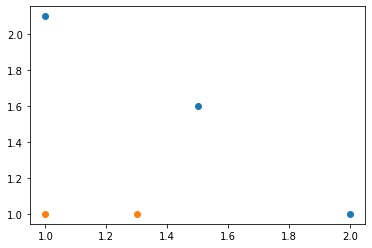

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def loadSimpData():
    """
    创建单层决策树的数据集
    Parameters:
        无
    Returns:
        dataMat - 数据矩阵
        classLabels - 数据标签
    """
    datMat = np.matrix([[ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels
def showDataSet(dataMat, labelMat):
    """
    数据可视化
    Parameters:
        dataMat - 数据矩阵
        labelMat - 数据标签
    Returns:
        无
    """
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)                                             #转换为numpy矩阵
    data_minus_np = np.array(data_minus)                                         #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])        #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1])     #负样本散点图
    plt.show()
    
dataArr,classLabels = loadSimpData()
showDataSet(dataArr,classLabels)

如果想要试着从某个坐标轴上选择一个值（即选择一条与坐标轴平行的直线$y=kx$或者$x=ky$）来将所有的蓝色圆点和橘色圆点分开，这显然是不可能的。

这就是单层决策树难以处理的一个著名问题。通过使用多颗单层决策树，我们可以构建出一个能够对该数据集完全正确分类的分类器。

下述代码的逻辑大致是这样的：

1. 首先按数据集的特征进行遍历，给定一个阈值，计算当前特征下的数据点被阈值分类的准确情况
2. 遍历所有特征和阈值，选出，这个非常弱的分类器最好的情况
3. 注意⚠️，这里最好的情况，是指对某一类的区分就够了，而不是整体。比如说我对样本是1预测准确率很高，但是-1很低，没关系，我们就只关注1预测准的地方。

In [2]:
def loadSimpData():
    """
    创建单层决策树的数据集
    Parameters:
        无
    Returns:
        dataMat - 数据矩阵
        classLabels - 数据标签
    """
    datMat = np.matrix([[ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    """
    单层决策树分类函数:依据阈值，非常弱智的判断矩阵中的值是否在阈值区间内；
    Parameters:
        dataMatrix - 数据矩阵
        dimen - 第dimen列，也就是第几个特征
        threshVal - 阈值
        threshIneq - 标志
    Returns:
        retArray - 分类结果
    """
    retArray = np.ones((np.shape(dataMatrix)[0],1))                #初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0         #如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0         #如果大于阈值,则赋值为-1
    return retArray

def buildStump(dataArr,classLabels,D):
    """
    找到数据集上最佳的单层决策树
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        D - 样本权重
    Returns:
        bestStump - 最佳单层决策树信息
        minError - 最小误差
        bestClasEst - 最佳的分类结果
    """
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    # 最小误差初始
    minError = float('inf')  
    # 遍历所有特征
    for i in range(n):                                                            
        # 获取当前特征中最小的值和最大值
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()        
        # 步长
        stepSize = (rangeMax - rangeMin) / numSteps                                
        for j in range(-1, int(numSteps) + 1):                                     
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)                     #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))                                 #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0                             #分类正确的,赋值为0
                weightedError = D.T * errArr                                      #计算误差
                print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:                                     #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

dataArr,classLabels = loadSimpData()
D = np.mat(np.ones((5, 1)) / 5)
bestStump,minError,bestClasEst = buildStump(dataArr,classLabels,D)
print('bestStump:\n', bestStump)
print('minError:\n', minError)
print('bestClasEst:\n', bestClasEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

从结果可以看出，预测最好的地方是：对于第一个特征，取阈值是1.3，判断都$\le$1.3 是很准的,准确率达80%。

接下来，使用AdaBoost算法提升分类器性能，将分类误差缩短到0，看下AdaBoost算法是如何实现的。

## 7.4 完整AdaBoost算法

下述代码的实现思路：
1. 首先，初始化一个均等的和为1的数据集权重矩阵D；
2. 依据D带入上节中的“弱学习器”中，返回当前矩阵D下最小错误率$ε$对应的的最优弱学习器参数；
3. 依据错误率，带入公式求得当前弱学习器的权重$\alpha$
4. 依据弱学习器的学习结果与真实结果之间的是否相等，计算下一轮“弱学习器”用到的权重矩阵D：计算错误的样本权重更大，正确的更小；
5. 不停迭代，直至错误率为0或者达到要求的迭代次数。

> `alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))`,其中1e-16 指0.0000000000000001，避免此次计算达到完全正确，导致除0溢出


In [3]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)                                            #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)     #构建单层决策树
        print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))         #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha                                          #存储弱学习算法权重
        weakClassArr.append(bestStump)                                      #存储单层决策树
        print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)     #计算e的指数项
        D = np.multiply(D, np.exp(expon))                                      
        D = D / D.sum()                                                        #根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst                                 
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))     #计算误差
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate)
        if errorRate == 0.0: break                                             #误差为0，退出循环
    return weakClassArr, aggClassEst

dataArr,classLabels = loadSimpData()
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
print(weakClassArr)
print(aggClassEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

## 7.5 非均衡问题

在大多数情况下不同类别的分类代价并不相等。比如有的时候我们会更在意是否“错杀”，或者有“遗漏”。有在本节中，我们将会考察一种新的分类器性能度量方法。

### 7.5.1 正确率、召回率

到现在为止，本书都是基于错误率：所有测试样例中错分的样例比例来衡量分类器任务的成功程度的。实际上，这样的度量错误掩盖了样例如何被分错的事实。

在机器学习中，有一个普遍适用的称为混淆矩阵（confusion matrix）的工具，它可以帮助人们更好地了解分类中的错误。

下图是一个二分类问题的混淆矩阵：



|          |      | 预测结果     | 预测结果     |
| -------- | ---- | ------------ | ------------ |
|          |      | +1           | -1           |
| 真实结果 | +1   | 真正例（TP） | 伪反例（FN） |
| 真实结果 | -1   | 伪正例（FP） | 真反例（TN） |


在分类中，当某个类别的重要性高于其他类别时，我们就可以利用上述定义来定义出多个比错误率更好的新指标。第一个指标是正确率,给出的是预测为正例的样本中的真正正例的比例.
$$
正确率Precision = \frac{TP}{TP+FP}
$$

第二个指标是召回率，给出的是预测为正例的真实正例占所有真实正例的比例。在召回率很大的分类器中，真正判错的正例的数目并不多。 
$$
召回率Recall = \frac{TP}{TP+FN}
$$

我们可以很容易构造一个高正确率或高召回率的分类器，但是很难同时保证两者成立。如果将任何样本都判为正例，那么召回率达到百分之百而此时正确率很低。构建一个同时使正确率和召回率最大的分类器是具有挑战性的。

### 7.5.2 ROC曲线

横轴是伪正例的比例（假阳率=FP/(FP+TN)），而纵轴是真正例的比例（真阳率=TP/(TP+FN)）。ROC曲线给出的是当阈值
变化时假阳率和真阳率的变化情况。左下角的点所对应的是将所有样例判为反例的情况，而右上角的点对应的则是将所有样例判为正例的情况。$y=x$直线，给出的是随机猜测的结果。

ROC曲线不但可以用于比较分类器，还可以基于成本效益（cost-versus-benefit）分析来做出决策。由于在不同的阈值下，不同的分类器的表现情况可能各不相同，因此以某种方式将它们组合起来或许会更有意义。如果只是简单地观察分类器的错误率，那么我们就难以得到这种更深入
的洞察效果了。 

在理想的情况下，最佳的分类器应该尽可能地处于左上角，这就意味着分类器在假阳率很低的同时获得了很高的真阳率。

对不同的ROC曲线进行比较的一个指标是曲线下的面积（Area Unser the Curve，AUC）。AUC给出的是分类器的平均性能值，当然它并不能完全代替对整条曲线的观察。一个完美分类器的AUC为1.0，而随机猜测的AUC则为0.5。

### 7.5.3 损失函数调整

除了调节分类器的阈值之外，我们还有一些其他可以用于处理非均衡分类代价的方法，其中的一种称为代价敏感的学习（cost-sensitive learning）。

在分类算法中，我们有很多方法可以用来引入代价信息。在AdaBoost中，可以基于代价函数来调整错误权重向量D。在朴素贝叶斯中，可以选择具有最小期望代价而不是最大概率的类别作为最后的结果。在SVM中，可以在代价函数中对于不同的类别选择不同的参数C。上述做法就会给较小类更多的权重，即在训练时，小类当中只允许更少的错误。

## 7.6 本章小结

本章我们使用非常简单的弱分类器，根据错误率给当前分类器设定权重；根据样本预测的正确与否，对样本进行权重区分，然后在新权重样本下进行新一轮的预测，重复直到错误率=0或达到指定的条件。